## Import

In [82]:
import os
import json
import pandas
import matplotlib.pyplot as plt
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import SyllableTokenizer
from lexicalrichness import LexicalRichness

## Metrics

### Word and Character count

In [83]:
def get_words_count(text):
    words = word_tokenize(text)
    return len(words)

### Flesch Reading Ease

In [84]:
def calculate_FRE_score(text:str, lang:str="fr") -> float:
    """Calculate Flesch Reading Ease per sentence

    en: 206.835 - 1.015 * (total_words/total_sentences) - 84.6 * (total_syllabes/total_words) 
    fr: 207 - 1.015 * (total_words/total_sentences) - 73.6 * (total_syllabes/total_words) 

    Args:
        text (str): a given text
    """

    x = 206.835
    y = 84.6
    total_words = 0
    total_syllabes = 0
    SSP = SyllableTokenizer()

    if lang=="fr":
        x = 207
        y = 73.6

    sentences = sent_tokenize(text)
    total_sentences = len(sentences)

    for sentence in sentences:
        words = word_tokenize(sentence)
        total_words += len(words)

        for word in words:
            syllabes = SSP.tokenize(word)
            total_syllabes += len(syllabes)
     
    return x - 1.015 * (total_words/total_sentences) - y * (total_syllabes/total_words)

### Lexical Richness

In [85]:

def calculate_LR(text:str, lang:str="fr") -> float:
    sentences = sent_tokenize(text)
    for sentence in sentences:
        lex = LexicalRichness(sentence)
        return lex.mtld()


### Get metrics

In [86]:
def get_metrics_from_file(fpath):

    # print(fpath.upper())
    fre_scores = []
    lr_scores = []
    word_count = []
    with open(fpath, "r", encoding="utf-8") as f:
        line = f.readline()
        while line:
            fre_scores.append(calculate_FRE_score(line))
            lr_scores.append(calculate_LR(line))
            word_count.append(get_words_count(line))
            line = f.readline()
            
    
    avg_fre_score = sum(fre_scores) / len(fre_scores)
    avg_lr_score = sum(lr_scores) / len(lr_scores)
    avg_word_count = sum(word_count) / len(word_count)

    return fre_scores, avg_fre_score, lr_scores, avg_lr_score, word_count, avg_word_count

## Datasets

#### Alector

In [87]:

def alector(path="alector_aligned"):
    dic = {}
    for folder in os.listdir(path):
        folderpath = os.path.join(path, folder)
        text_type = folderpath.split("\\")[-1]

        for fname in os.listdir(folderpath):
            fpath = os.path.join(folderpath, fname)
            name, data_type = fname.split("_")
            name = name
            data_type = data_type.replace(".txt", "")
            if name not in dic.keys(): 
                dic[name] = {}
                dic[name]["text_type"] = text_type

            fre_scores, avg_fre_score, lr_scores, avg_lr_score, word_count, avg_word_count = get_metrics_from_file(fpath)
            dic[name][data_type] = {}
            dic[name][data_type]["fre_scores"] = fre_scores
            dic[name][data_type]["avg_fre_score"] = avg_fre_score
            dic[name][data_type]["lr_scores"] = lr_scores
            dic[name][data_type]["avg_lr_score"] = avg_lr_score
            dic[name][data_type]["word_count"] = word_count
            dic[name][data_type]["avg_word_count"] = avg_word_count

    keys = dic.keys()
    sorted_keys = sorted(keys)
    sorted_dic = {}
    for key in sorted_keys:
        sorted_dic[key] = dic[key]

    with open('alector_metrics.json', 'w') as fp:
        json.dump(sorted_dic, fp)

    return sorted_dic



In [88]:
def alector_plot(dic, text_type:str, score:str, lims:list, only_hist=True):
    
    source_avg = []
    target_avg = []
    x = []
    for item in dic:
        if dic[item]["text_type"] == text_type or text_type == "everything":
            source_avg.append(dic[item]["source"][score])
            target_avg.append(dic[item]["target"][score])
            x.append(item)

    print(len(source_avg), "ressources")
        
    if not only_hist:
        plt.figure(figsize=(20,5))
        plt.plot(x, source_avg, label = "source")
        plt.axhline(y=sum(source_avg) / len(source_avg), color='cyan', linestyle='--', linewidth=2, label='Avg_source')
        plt.plot(x, target_avg, label = "target")
        plt.axhline(y=sum(target_avg) / len(target_avg), color='red', linestyle='--', linewidth=2, label='Avg_target')

        plt.xlabel('Number of the file')
        plt.ylabel(f'{score} Score')
        plt.title(f"{score} score per file ({text_type})")

        plt.ylim(lims[0], lims[1])
        plt.legend()
        plt.show()

    plt.figure(figsize=(20,5))
    substracted = list()
    if score == "avg_fre_score":
        for tar_item, src_item in zip(target_avg, source_avg):
            substracted.append(tar_item - src_item)
        label = "target - source"

        plt.hist(substracted, label = label)

    if score == "avg_lr_score"  or score == "avg_word_count":
        for tar_item, src_item in zip(target_avg, source_avg):
            substracted.append(src_item - tar_item)
        label = "source - target"

        plt.hist(substracted, label = label)
        
    plt.legend()
    plt.title(f"{score} score difference per file ({text_type}) - [{label}]")


37 ressources
37 ressources
37 ressources


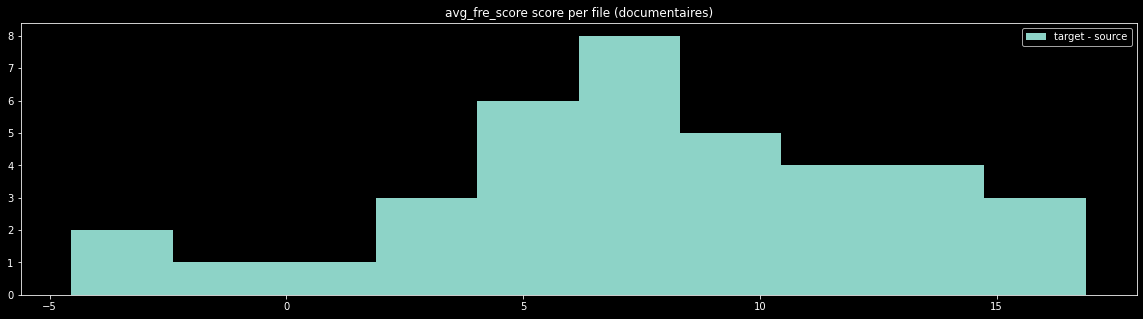

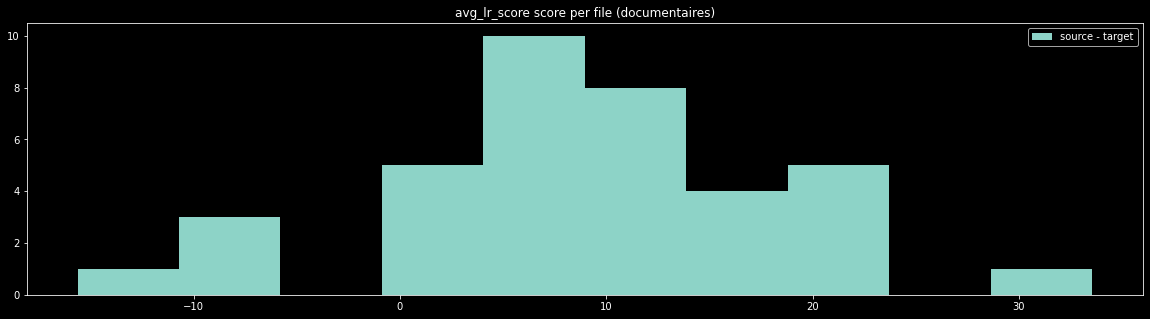

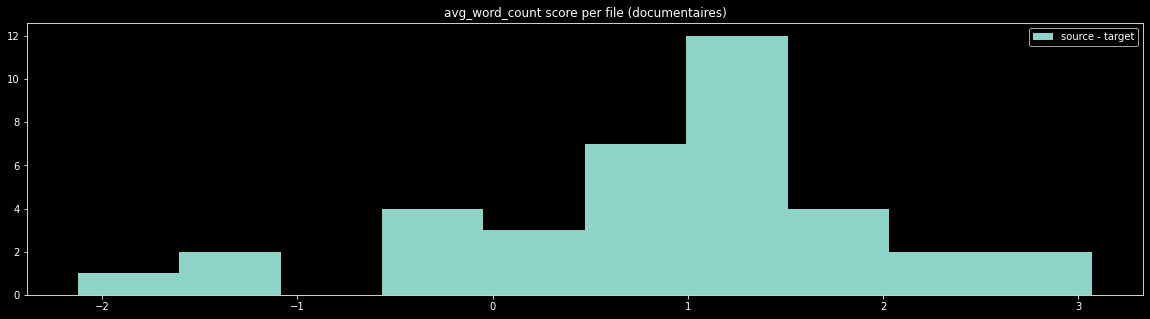

In [89]:
try:
    with open('alector_metrics.json', 'r') as fp:
        dic = json.load(fp)
except:
    dic = alector()

# text_types = ["contes", "documentaires", "everything"]
text_types = ["documentaires"]

for text_type in text_types:
    # Flesch Reading Ease
    alector_plot(dic, text_type, "avg_fre_score", [0, 100])
    # Measure of Lexical Diversity (McCarthy 2005, McCarthy and Jarvis 2010)
    alector_plot(dic, text_type, "avg_lr_score", [0, 100])
    # Word count
    alector_plot(dic, text_type, "avg_word_count", [0, 50])

#### Translated Datasets Comparisons